In [2]:
import tensorflow as tf
import numpy as np

In [3]:
import tensorflow.contrib.keras.api.keras as keras
from tensorflow.contrib.keras.api.keras.preprocessing.image import \
ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:
from tensorflow.contrib.keras.api.keras import *

In [4]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [18]:
img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [30]:
img

AttributeError: 'JpegImageFile' object has no attribute 'get_shape'

In [11]:
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import Conv2D, MaxPooling2D
from tensorflow.contrib.keras.api.keras.layers import Activation, Dropout, Flatten, Dense

In [31]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [32]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 1 classes.


In [55]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights=None)
model.load_weights('/Users/Gundeep/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [59]:
img_width, img_height = 150, 150

generator = datagen.flow_from_directory(
        'data/train',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_train = model.predict_generator(
        generator, 2000 // batch_size)

Found 2000 images belonging to 2 classes.


In [64]:
bottleneck_features_train.shape
np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

In [65]:
generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = model.predict_generator(
        generator, 2000 // batch_size)
np.save(open('bottleneck_features_validation.npy', 'wb'),
        bottleneck_features_validation)

Found 2002 images belonging to 2 classes.


In [25]:
nb_train_samples = 2000
nb_validation_samples = 2000
epochs = 100
batch_size = 16
top_model_weights_path = 'bottleneck_fc_model.h5'

def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_labels = np.array(
        [0] * 1000 + [1] * 1000)

    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    validation_labels = np.array(
        [0] * 1000 + [1] * 1000)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    mod_his = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    return mod_his

In [26]:
mod_hist = train_top_model()

Train on 2000 samples, validate on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 0s - loss: 4.3959 - acc: 0.7045 - val_loss: 2.9016 - val_acc: 0.8045
Epoch 2/100
2000/2000 [==============================] - 0s - loss: 3.2661 - acc: 0.7850 - val_loss: 2.3444 - val_acc: 0.8455
Epoch 3/100
2000/2000 [==============================] - 0s - loss: 2.3643 - acc: 0.8430 - val_loss: 2.1856 - val_acc: 0.8555
Epoch 4/100
2000/2000 [==============================] - 0s - loss: 2.1543 - acc: 0.8585 - val_loss: 2.3106 - val_acc: 0.8495
Epoch 5/100
2000/2000 [==============================] - 0s - loss: 2.2369 - acc: 0.8545 - val_loss: 2.2521 - val_acc: 0.8530
Epoch 6/100
2000/2000 [==============================] - 0s - loss: 2.1095 - acc: 0.8635 - val_loss: 3.3628 - val_acc: 0.7805
Epoch 7/100
2000/2000 [==============================] - 0s - loss: 2.0088 - acc: 0.8690 - val_loss: 2.6961 - val_acc: 0.8260
Epoch 8/100
2000/2000 [==============================] - 0s - loss: 1.

2000/2000 [==============================] - 0s - loss: 0.5485 - acc: 0.9655 - val_loss: 1.8109 - val_acc: 0.8845
Epoch 66/100
2000/2000 [==============================] - 0s - loss: 0.6106 - acc: 0.9615 - val_loss: 1.8020 - val_acc: 0.8855
Epoch 67/100
2000/2000 [==============================] - 0s - loss: 0.5800 - acc: 0.9610 - val_loss: 1.8495 - val_acc: 0.8835
Epoch 68/100
2000/2000 [==============================] - 0s - loss: 0.5790 - acc: 0.9625 - val_loss: 1.9841 - val_acc: 0.8730
Epoch 69/100
2000/2000 [==============================] - 0s - loss: 0.6142 - acc: 0.9600 - val_loss: 1.8047 - val_acc: 0.8855
Epoch 70/100
2000/2000 [==============================] - 0s - loss: 0.5405 - acc: 0.9655 - val_loss: 1.9447 - val_acc: 0.8765
Epoch 71/100
2000/2000 [==============================] - 0s - loss: 0.5797 - acc: 0.9635 - val_loss: 1.8343 - val_acc: 0.8820
Epoch 72/100
2000/2000 [==============================] - 0s - loss: 0.4979 - acc: 0.9675 - val_loss: 1.8720 - val_acc: 0.87

In [27]:
import matplotlib.pyplot as plt
def plot_history(plottable_history,plotevery=10):
    #  print(plottable_history.history.keys())
    #  "Accuracy"
    plt.plot(plottable_history.history['acc'][::plotevery])
    plt.plot(plottable_history.history['val_acc'][::plotevery])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(plottable_history.history['loss'][::plotevery])
    plt.plot(plottable_history.history['val_loss'][::plotevery])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

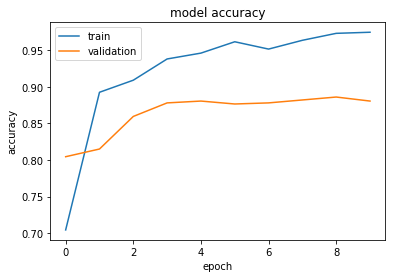

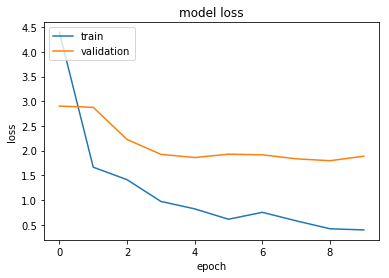

In [28]:
plot_history(mod_hist)